In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_swiss_roll

## 0.Data


In [2]:
make_swiss_roll

<function sklearn.datasets._samples_generator.make_swiss_roll(n_samples=100, *, noise=0.0, random_state=None, hole=False)>

In [3]:
n_samples = 10000

data, _ = make_swiss_roll(n_samples)
data = data[:, [2, 0]] / 10
data = data * np.array([-1, 1])
print(data.shape)

(10000, 2)


(-2.0, 2.0)

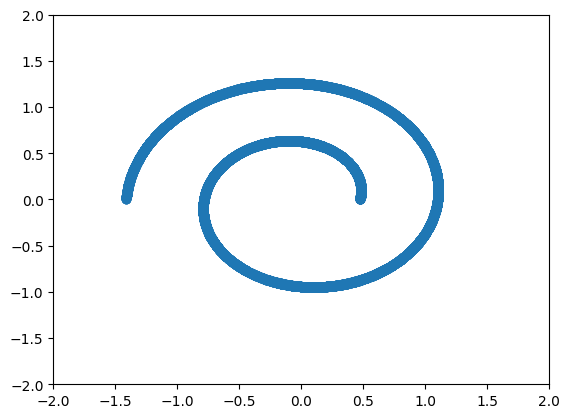

In [ ]:
plt.scatter(data[:, 0], data[:, 1])
plt.xlim([-2, 2])
plt.ylim([-2, 2])

## 1. Implement Forward

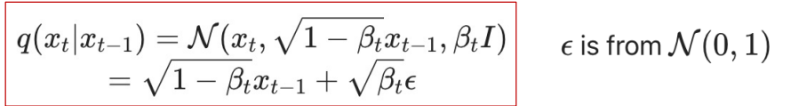

In [ ]:
def forward_process(data, T, betas):
    for t in range(T):
        beta_t = betas[t]
        mu = data * torch.sqrt(1 - beta_t)
        std = torch.sqrt(beta_t)
        # Sample from q(x_t | x_{t-1})
        data = mu + torch.randn_like(data) * std # data ~ N(mu, std)
    return data

In [ ]:
T = 25
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
xT = forward_process(torch.from_numpy(data), T, betas)
betas

tensor([1.0005e-05, 1.0015e-05, 1.0047e-05, 1.0151e-05, 1.0486e-05, 1.1560e-05,
        1.5010e-05, 2.6089e-05, 6.1659e-05, 1.7583e-04, 5.4187e-04, 1.7113e-03,
        5.4057e-03, 1.6674e-02, 4.7669e-02, 1.1327e-01, 1.9823e-01, 2.5865e-01,
        2.8577e-01, 2.9542e-01, 2.9856e-01, 2.9955e-01, 2.9986e-01, 2.9996e-01,
        2.9999e-01])

In [ ]:
print(xT.mean(0))
print(xT.std(0))
print(xT.shape)

tensor([-0.0089,  0.0435], dtype=torch.float64)
tensor([0.9849, 0.9876], dtype=torch.float64)
torch.Size([10000, 2])


(-2.0, 2.0)

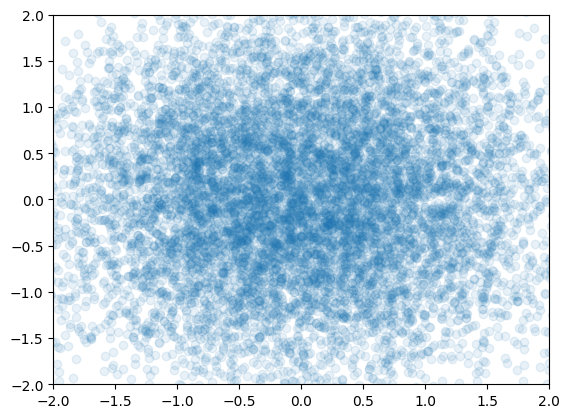

In [ ]:
plt.scatter(xT[:, 0].data.numpy(), xT[:, 1].data.numpy(), alpha=0.1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])

### Kernel Trick Implementation

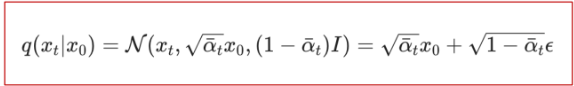

In [ ]:
class DiffusionModel():

    def __init__(self, T):

        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)

    def forward_process(self, x0, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'

        t = t -1 # Because we start indexing at 0

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        return mu + epsilon * std # data ~ N(mu, std)

model = DiffusionModel(T=50)
x0 = torch.from_numpy(data)
xT = model.forward_process(x0, 25)

In [ ]:
model = DiffusionModel(T=50)
x0 = torch.from_numpy(data)
xT = model.forward_process(x0, 25)

(-2.0, 2.0)

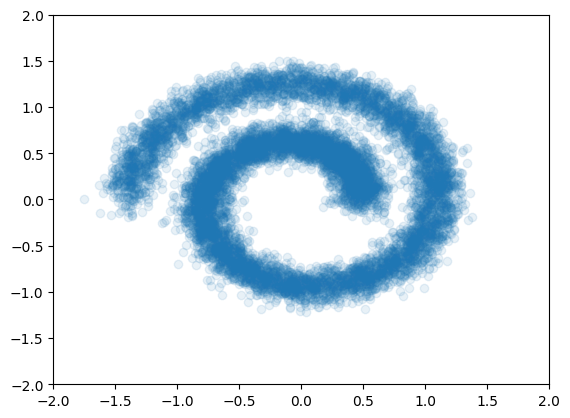

In [ ]:
plt.scatter(xT[:, 0].data.numpy(), xT[:, 1].data.numpy(), alpha=0.1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])

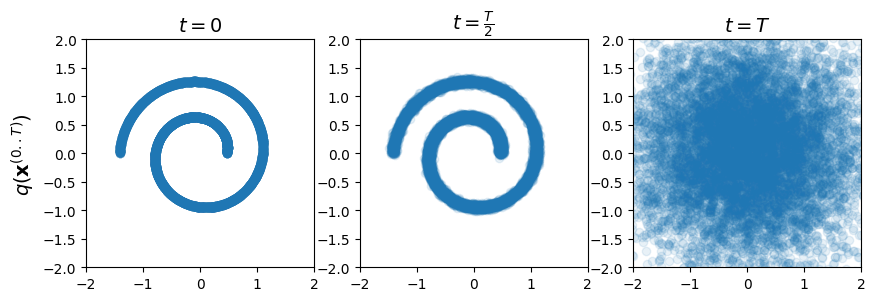

In [ ]:
fontsize = 14
fig = plt.figure(figsize=(10, 3))

data = [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)]
for i in range(3):

    plt.subplot(1, 3, 1+i)
    plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')

    if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
    if i == 0: plt.title(r'$t=0$', fontsize=fontsize)
    if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
    if i == 2: plt.title(r'$t=T$', fontsize=fontsize)
plt.savefig('forward_process.png', bbox_inches='tight')